### Importação de bibliotecas python

In [1]:
import os
import json
import pickle
import neptune
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

### Importação de módulos do projeto

In [2]:
os.chdir("..")

In [3]:
from calysto.feature_engineering import Engineering

### Load Settings

In [4]:
feature_params = json.load(open("settings/dataprep_improved.json", "r"))

### Read Data

In [5]:
train = pd.read_csv("data/train.csv")

In [6]:
test = pd.read_csv("data/test.csv")

### Exploratory Analysis

In [7]:
!cat data/data_description.txt

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM

### Análise descritiva

In [8]:
X = train[list(train.columns)]
y = train[["SalePrice"]]

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=1903)

In [11]:
X_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
788,789,20,RM,50.0,6000,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2008,WD,Normal,107900
903,904,20,RL,50.0,14859,Pave,NaN,IR1,HLS,AllPub,...,0,NaN,NaN,NaN,0,8,2006,New,Partial,240000
1297,1298,180,RM,35.0,3675,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2006,New,Partial,140000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
649,650,180,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,12,2007,WD,Normal,84500


In [12]:
variavel_analise =  "Condition1"

In [13]:
DescribeCount = test.\
    fillna('missing').\
    groupby([variavel_analise])['Id'].\
    describe()[['count']].\
    apply(lambda x: round(x, 1)).\
    reset_index()

DescribeCount

,Condition1,count
0,Artery,44.0
1,Feedr,83.0
2,Norm,1251.0
3,PosA,12.0
4,PosN,20.0
5,RRAe,17.0
6,RRAn,24.0
7,RRNe,4.0
8,RRNn,4.0


In [14]:
DescribeCount = X_train .\
    fillna('missing').\
    groupby([variavel_analise])['SalePrice'].\
    describe().\
    apply(lambda x: round(x, 1)).\
    reset_index()

DescribeCount

,Condition1,count,mean,std,min,25%,50%,75%,max
0,Artery,41.0,138129.3,70989.1,66500.0,105000.0,119900.0,143000.0,475000.0
1,Feedr,64.0,146846.6,42866.5,52500.0,125000.0,143500.0,170000.0,244600.0
2,Norm,1008.0,185867.5,82438.8,34900.0,132000.0,169700.0,222000.0,755000.0
3,PosA,7.0,224571.4,56402.9,180000.0,187500.0,190000.0,246000.0,335000.0
4,PosN,11.0,208795.5,72848.5,109500.0,166500.0,200000.0,219250.0,385000.0
5,RRAe,9.0,144988.9,18302.0,112000.0,138500.0,143900.0,158000.0,171000.0
6,RRAn,22.0,187982.8,71296.5,79500.0,152393.8,175950.0,207972.5,423000.0
7,RRNe,2.0,190750.0,5303.3,187000.0,188875.0,190750.0,192625.0,194500.0
8,RRNn,4.0,238000.0,85837.1,128000.0,192500.0,252000.0,297500.0,320000.0


In [15]:
X_train[variavel_analise].fillna('missing').unique()

array(['Norm', 'PosN', 'RRNn', 'RRAn', 'Feedr', 'Artery', 'PosA', 'RRAe',
       'RRNe'], dtype=object)

In [16]:
exp_data = X_train[["Id", variavel_analise, "SalePrice"]].fillna("missing")

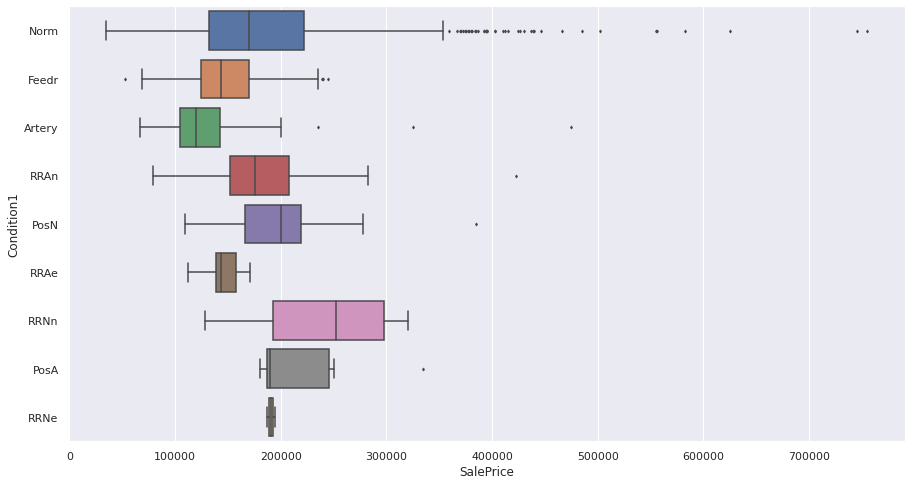

In [17]:
plt.figure(figsize=(15,8))
ax = sns.boxplot(x="SalePrice", y=variavel_analise, 
                 data=exp_data.sort_values("SalePrice"),
                 orient="h", fliersize=2)

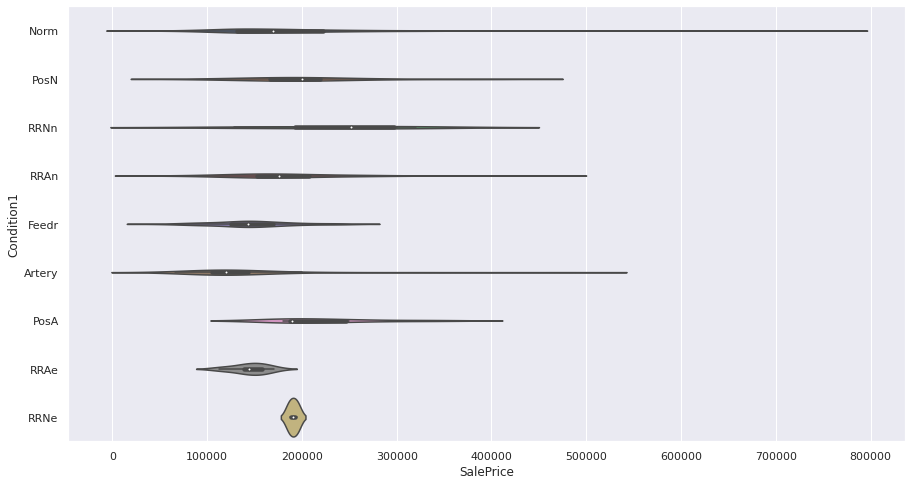

In [18]:
plt.figure(figsize=(15,8))
ax = sns.violinplot(x="SalePrice", y=variavel_analise, 
                 data=exp_data,
                 orient="h", fliersize=2)

In [19]:
import scipy

IndexError: list index out of range

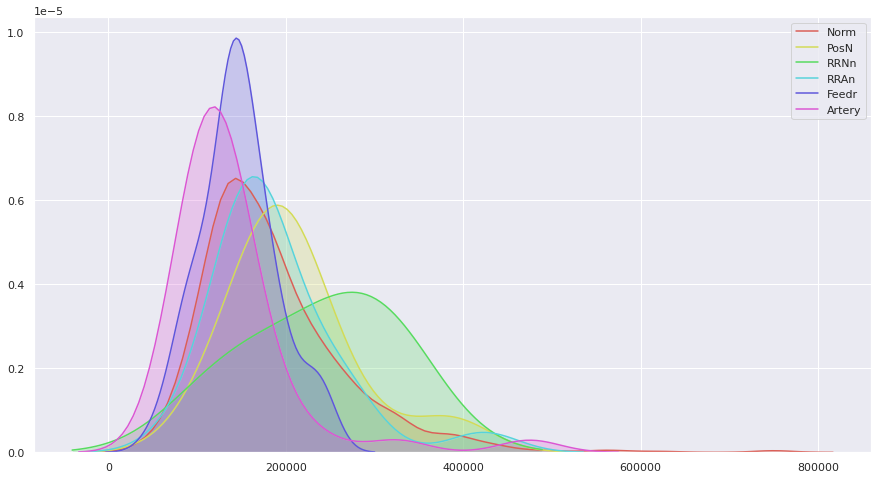

In [20]:
plt.figure(figsize=(15,8))
i = 0
for classe in exp_data[variavel_analise].unique():
    d = pd.DataFrame(exp_data.loc[exp_data[variavel_analise] == classe, "SalePrice"])
    d.rename(columns={'SalePrice': classe}, inplace=True)
    p1=sns.kdeplot(d[classe],
                   shade=True, 
                   color=sns.color_palette("hls", 12)[i])
    i=i+2

In [ ]:
X_train.loc[X_train["Id"] == 124]